<a href="https://colab.research.google.com/github/AliveBotswana/alivebotswana-eportfolio-msc-ai/blob/main/DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1: Install required packages (if not already installed in Colab)
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 11.4 MB/s eta 0:00:00


In [2]:
# Cell 2: Imports
# We use these comprehensive imports to support the full pipeline:
# - TensorFlow/Keras for model building, training, and preprocessing
# - NumPy and Matplotlib for data handling and basic visualization
# - Scikit-learn for data splitting and evaluation metrics
# - Seaborn for enhanced visualizations like heatmaps
# - Keras Tuner for hyperparameter optimization
# - OS and Shutil for file management during tuning
# This aligns with best practices for a complete deep learning workflow in image classification,
# allowing us to choose and evaluate architectures, activation functions, etc., as per the key takeaways.
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import itertools
import keras_tuner as kt
import os
import shutil
%matplotlib inline

In [3]:
# Cell 3: Define class names and load/prepare dataset
# Dataset: CIFAR-10, a standard for image classification, similar to ImageNet mentioned in the notes.
# We split into training, validation, and test sets as emphasized – crucial for evaluating model performance.
# Normalization and one-hot encoding prepare data for the model.
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Load and prepare CIFAR-10 dataset
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values to [0, 1]
x_train_full = x_train_full.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert labels to one-hot encoding
y_train_full = to_categorical(y_train_full, 10)
y_test = to_categorical(y_test, 10)

# Split training data into train and validation sets (80/20 split, stratified)
# This follows good practices for dataset splitting, depending on size (here, 50k training images).
x_train, x_val, y_train, y_val = train_test_split(
    x_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

print(f"Training: {x_train.shape}, Validation: {x_val.shape}, Test: {x_test.shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step
Training: (40000, 32, 32, 3), Validation: (10000, 32, 32, 3), Test: (10000, 32, 32, 3)


In [4]:
# Cell 4: Data augmentation and generators
# Data augmentation helps improve generalization, a common practice for image recognition tasks.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    shear_range=0.1,
    fill_mode='nearest'
)

# No augmentation for validation
val_datagen = ImageDataGenerator()

# Create data generators
# Batch size: 128, chosen as a balance for efficiency (as per notes on choosing batch size).
train_generator = train_datagen.flow(x_train, y_train, batch_size=128)
val_generator = val_datagen.flow(x_val, y_val, batch_size=128)

In [5]:
# Cell 5: Define custom CNN model
# Architecture: Custom deep CNN, chosen after research for image classification.
# Uses ReLU activation as suggested in notes (preferred over Sigmoid for deep networks to avoid vanishing gradients).
# Weights are initialized automatically and updated via backpropagation during training.
def create_custom_cnn():
    """
    Create a custom deep Convolutional Neural Network (CNN) for CIFAR-10 classification.
    The architecture includes multiple convolutional blocks with batch normalization,
    max pooling, and dropout for regularization.
    """
    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Fourth Convolutional Block
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),

        # Dense Layers
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])

    return model

In [6]:
# Cell 6: Define transfer learning model
# Transfer learning architecture: ResNet50 (one of the most famous, as per notes), pre-trained on ImageNet.
# Chosen based on research for object recognition/image classification tasks like CIFAR-10.
# Base model frozen, custom layers added for adaptation.
def create_transfer_model():
    """
    Create a transfer learning model using pre-trained ResNet50 as the base.
    The base model is frozen, and custom dense layers are added for classification.
    """
    base_model = applications.ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    base_model.trainable = False  # Freeze base model weights

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])

    return model

In [7]:
# Cell 7: Define compile and train function
# Loss function: Categorical crossentropy (standard for multi-class classification).
# Optimizer: Adam with learning rate 0.001 (chosen as per common practices).
# Epochs: Up to 100, with early stopping.
# These are user-chosen hyperparameters as highlighted in the notes.
def compile_and_train_model(model, model_name, use_generator=True):
    """
    Compile and train the model with Adam optimizer, early stopping, learning rate reduction,
    and model checkpointing.
    """
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    callbacks = [
        EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-7, verbose=1),
        ModelCheckpoint(f'best_{model_name}.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
    ]

    epochs = 100
    batch_size = 128

    if use_generator:
        history = model.fit(
            train_generator,
            epochs=epochs,
            validation_data=val_generator,
            callbacks=callbacks,
            verbose=1
        )
    else:
        history = model.fit(
            x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_val, y_val),
            callbacks=callbacks,
            verbose=1
        )

    return history, model

In [8]:
# Cell 8: Create and train custom CNN (Run this cell to train; it may take time)
# Training process: Backpropagation updates weights automatically.
custom_cnn = create_custom_cnn()
custom_cnn.summary()
print("Training Custom Deep CNN...")
history_custom, trained_custom = compile_and_train_model(custom_cnn, "custom_cnn")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,444,650 (5.51 MB)

 Trainable params: 1,441,194 (5.50 MB)

 Non-trainable params: 3,456 (13.50 KB)

Training Custom Deep CNN...
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.2264 - loss: 2.5092
Epoch 1: val_accuracy improved from -inf to 0.14740, saving model to best_custom_cnn.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 63s 135ms/step - accuracy: 0.2266 - loss: 2.5080 - val_accuracy: 0.1474 - val_loss: 3.4404 - learning_rate: 0.0010
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.4331 - loss: 1.5921
Epoch 2: val_accuracy improved from 0.14740 to 0.50630, saving model to best_custom_cnn.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 95ms/step - accuracy: 0.4332 - loss: 1.5918 - val_accuracy: 0.5063 - val_loss: 1.3893 - learning_rate: 0.0010
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.5353 - loss: 1.3134
Epoch 3: val_accuracy improved from 0.50630 to 0.60740, saving model to best_custom_cnn.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 98ms/step - accuracy: 0.5354 - loss: 1.3132 - val_accuracy: 0.6074 - val_loss: 1.1658 - learning_rate: 0.0010
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.5914 - loss: 1.1656
Epoch 4: val_accuracy improved from 0.60740 to 0.61800, saving model to best_custom_cnn.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 109ms/step - accuracy: 0.5914 - loss: 1.1655 - val_accuracy: 0.6180 - val_loss: 1.1640 - learning_rate: 0.0010
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6371 - loss: 1.0446
Epoch 5: val_accuracy improved from 0.61800 to 0.66770, saving model to best_custom_cnn.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.6372 - loss: 1.0445 - val_accuracy: 0.6677 - val_loss: 0.9973 - learning_rate: 0.0010
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.6729 - loss: 0.9516
Epoch 6: val_accuracy improved from 0.66770 to 0.68500, saving model to best_custom_cnn.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 95ms/step - accuracy: 0.6729 - loss: 0.9516 - val_accuracy: 0.6850 - val_loss: 0.9475 - learning_rate: 0.0010
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.6981 - loss: 0.8856
Epoch 7: val_accuracy improved from 0.68500 to 0.72300, saving model to best_custom_cnn.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 100ms/step - accuracy: 0.6981 - loss: 0.8856 - val_accuracy: 0.7230 - val_loss: 0.8385 - learning_rate: 0.0010
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.7190 - loss: 0.8205
Epoch 8: val_accuracy improved from 0.72300 to 0.74300, saving model to best_custom_cnn.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 89ms/step - accuracy: 0.7190 - loss: 0.8206 - val_accuracy: 0.7430 - val_loss: 0.7629 - learning_rate: 0.0010
Epoch 9/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7325 - loss: 0.7960
Epoch 9: val_accuracy improved from 0.74300 to 0.74910, saving model to best_custom_cnn.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 87ms/step - accuracy: 0.7325 - loss: 0.7960 - val_accuracy: 0.7491 - val_loss: 0.7574 - learning_rate: 0.0010
Epoch 10/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7440 - loss: 0.7618
Epoch 10: val_accuracy improved from 0.74910 to 0.75040, saving model to best_custom_cnn.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 88ms/step - accuracy: 0.7440 - loss: 0.7618 - val_accuracy: 0.7504 - val_loss: 0.7493 - learning_rate: 0.0010
Epoch 11/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.7591 - loss: 0.7277
Epoch 11: val_accuracy improved from 0.75040 to 0.75370, saving model to best_custom_cnn.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 89ms/step - accuracy: 0.7591 - loss: 0.7277 - val_accuracy: 0.7537 - val_loss: 0.7296 - learning_rate: 0.0010
Epoch 12/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7628 - loss: 0.7068
Epoch 12: val_accuracy improved from 0.75370 to 0.79570, saving model to best_custom_cnn.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 88ms/step - accuracy: 0.7628 - loss: 0.7068 - val_accuracy: 0.7957 - val_loss: 0.6068 - learning_rate: 0.0010
Epoch 13/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7799 - loss: 0.6632
Epoch 13: val_accuracy did not improve from 0.79570
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.7799 - loss: 0.6632 - val_accuracy: 0.7632 - val_loss: 0.6995 - learning_rate: 0.0010
Epoch 14/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7824 - loss: 0.6533
Epoch 14: val_accuracy improved from 0.79570 to 0.81220, saving model to best_custom_cnn.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.7824 - loss: 0.6533 - val_accuracy: 0.8122 - val_loss: 0.5421 - learning_rate: 0.0010
Epoch 15/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7887 - loss: 0.6369
Epoch 15: val_accuracy did not improve from 0.81220
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.7887 - loss: 0.6369 - val_accuracy: 0.7989 - val_loss: 0.5987 - learning_rate: 0.0010
Epoch 16/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7948 - loss: 0.6167
Epoch 16: val_accuracy did not improve from 0.81220
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.7948 - loss: 0.6167 - val_accuracy: 0.8100 - val_loss: 0.5561 - learning_rate: 0.0010
Epoch 17/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.7973 - loss: 0.6013
Epoch 17: val_accuracy improved from 0.81220 to 0.81800, saving model to best_custom_cnn.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.7973 - loss: 0.6013 - val_accuracy: 0.8180 - val_loss: 0.5364 - learning_rate: 0.0010
Epoch 18/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.7997 - loss: 0.5996
Epoch 18: val_accuracy did not improve from 0.81800
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 84ms/step - accuracy: 0.7997 - loss: 0.5996 - val_accuracy: 0.8066 - val_loss: 0.5724 - learning_rate: 0.0010
Epoch 19/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8072 - loss: 0.5735
Epoch 19: val_accuracy did not improve from 0.81800
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.8072 - loss: 0.5735 - val_accuracy: 0.7840 - val_loss: 0.6525 - learning_rate: 0.0010
Epoch 20/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8109 - loss: 0.5574
Epoch 20: val_accuracy did not improve from 0.81800
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 84ms/step - accuracy: 0.8109 - loss: 0.5574 - val_accuracy: 0.7870 - val_loss: 0.6424 - learning_rate: 0.0010
Epoch

313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 90ms/step - accuracy: 0.8140 - loss: 0.5547 - val_accuracy: 0.8325 - val_loss: 0.5060 - learning_rate: 0.0010
Epoch 23/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8243 - loss: 0.5272
Epoch 23: val_accuracy did not improve from 0.83250
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 87ms/step - accuracy: 0.8243 - loss: 0.5272 - val_accuracy: 0.8257 - val_loss: 0.5239 - learning_rate: 0.0010
Epoch 24/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8232 - loss: 0.5234
Epoch 24: val_accuracy did not improve from 0.83250
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.8232 - loss: 0.5235 - val_accuracy: 0.8173 - val_loss: 0.5335 - learning_rate: 0.0010
Epoch 25/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.8273 - loss: 0.5139
Epoch 25: val_accuracy did not improve from 0.83250
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 88ms/step - accuracy: 0.8273 - loss: 0.5139 - val_accuracy: 0.8098 - val_loss: 0.5717 - learning_rate: 0.0010
Epoch

313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 87ms/step - accuracy: 0.8317 - loss: 0.4999 - val_accuracy: 0.8370 - val_loss: 0.4976 - learning_rate: 0.0010
Epoch 29/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8413 - loss: 0.4743
Epoch 29: val_accuracy improved from 0.83700 to 0.84480, saving model to best_custom_cnn.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 87ms/step - accuracy: 0.8412 - loss: 0.4744 - val_accuracy: 0.8448 - val_loss: 0.4679 - learning_rate: 0.0010
Epoch 30/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8420 - loss: 0.4711
Epoch 30: val_accuracy did not improve from 0.84480
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.8420 - loss: 0.4711 - val_accuracy: 0.7961 - val_loss: 0.6146 - learning_rate: 0.0010
Epoch 31/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8419 - loss: 0.4759
Epoch 31: val_accuracy improved from 0.84480 to 0.85760, saving model to best_custom_cnn.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.8419 - loss: 0.4759 - val_accuracy: 0.8576 - val_loss: 0.4241 - learning_rate: 0.0010
Epoch 32/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8474 - loss: 0.4554
Epoch 32: val_accuracy did not improve from 0.85760
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.8474 - loss: 0.4554 - val_accuracy: 0.8457 - val_loss: 0.4658 - learning_rate: 0.0010
Epoch 33/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8499 - loss: 0.4517
Epoch 33: val_accuracy did not improve from 0.85760
313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 90ms/step - accuracy: 0.8499 - loss: 0.4517 - val_accuracy: 0.8570 - val_loss: 0.4326 - learning_rate: 0.0010
Epoch 34/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8454 - loss: 0.4552
Epoch 34: val_accuracy did not improve from 0.85760
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.8454 - loss: 0.4552 - val_accuracy: 0.8124 - val_loss: 0.5867 - learning_rate: 0.0010
Epoch

313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.8601 - loss: 0.4237 - val_accuracy: 0.8601 - val_loss: 0.4430 - learning_rate: 0.0010
Epoch 40/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.8626 - loss: 0.4054
Epoch 40: val_accuracy did not improve from 0.86010
313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 88ms/step - accuracy: 0.8626 - loss: 0.4054 - val_accuracy: 0.8474 - val_loss: 0.4665 - learning_rate: 0.0010
Epoch 41/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8637 - loss: 0.4132
Epoch 41: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 41: val_accuracy did not improve from 0.86010
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.8637 - loss: 0.4132 - val_accuracy: 0.8500 - val_loss: 0.4558 - learning_rate: 0.0010
Epoch 42/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8731 - loss: 0.3733
Epoch 42: val_accuracy improved from 0.86010 to 0.86790, saving model to best_custom_cnn.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.8731 - loss: 0.3733 - val_accuracy: 0.8679 - val_loss: 0.4056 - learning_rate: 2.0000e-04
Epoch 43/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8799 - loss: 0.3569
Epoch 43: val_accuracy improved from 0.86790 to 0.87800, saving model to best_custom_cnn.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.8799 - loss: 0.3569 - val_accuracy: 0.8780 - val_loss: 0.3729 - learning_rate: 2.0000e-04
Epoch 44/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8819 - loss: 0.3466
Epoch 44: val_accuracy did not improve from 0.87800
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 87ms/step - accuracy: 0.8819 - loss: 0.3467 - val_accuracy: 0.8745 - val_loss: 0.3846 - learning_rate: 2.0000e-04
Epoch 45/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8863 - loss: 0.3376
Epoch 45: val_accuracy improved from 0.87800 to 0.87980, saving model to best_custom_cnn.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.8863 - loss: 0.3376 - val_accuracy: 0.8798 - val_loss: 0.3756 - learning_rate: 2.0000e-04
Epoch 46/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8879 - loss: 0.3283
Epoch 46: val_accuracy did not improve from 0.87980
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.8879 - loss: 0.3284 - val_accuracy: 0.8789 - val_loss: 0.3747 - learning_rate: 2.0000e-04
Epoch 47/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.8888 - loss: 0.3265
Epoch 47: val_accuracy did not improve from 0.87980
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 88ms/step - accuracy: 0.8888 - loss: 0.3265 - val_accuracy: 0.8794 - val_loss: 0.3690 - learning_rate: 2.0000e-04
Epoch 48/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8928 - loss: 0.3160
Epoch 48: val_accuracy did not improve from 0.87980
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.8927 - loss: 0.3161 - val_accuracy: 0.8724 - val_loss: 0.3919 - learning_rate: 

313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 87ms/step - accuracy: 0.8891 - loss: 0.3255 - val_accuracy: 0.8817 - val_loss: 0.3569 - learning_rate: 2.0000e-04
Epoch 51/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8929 - loss: 0.3176
Epoch 51: val_accuracy improved from 0.88170 to 0.88290, saving model to best_custom_cnn.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.8930 - loss: 0.3176 - val_accuracy: 0.8829 - val_loss: 0.3583 - learning_rate: 2.0000e-04
Epoch 52/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8928 - loss: 0.3119
Epoch 52: val_accuracy did not improve from 0.88290
313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 90ms/step - accuracy: 0.8928 - loss: 0.3119 - val_accuracy: 0.8765 - val_loss: 0.3770 - learning_rate: 2.0000e-04
Epoch 53/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8946 - loss: 0.3089
Epoch 53: val_accuracy did not improve from 0.88290
313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 89ms/step - accuracy: 0.8946 - loss: 0.3089 - val_accuracy: 0.8788 - val_loss: 0.3779 - learning_rate: 2.0000e-04
Epoch 54/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.8950 - loss: 0.3066
Epoch 54: val_accuracy improved from 0.88290 to 0.88410, saving model to best_custom_cnn.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 92ms/step - accuracy: 0.8950 - loss: 0.3067 - val_accuracy: 0.8841 - val_loss: 0.3622 - learning_rate: 2.0000e-04
Epoch 55/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8961 - loss: 0.3035
Epoch 55: val_accuracy did not improve from 0.88410
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.8961 - loss: 0.3035 - val_accuracy: 0.8830 - val_loss: 0.3618 - learning_rate: 2.0000e-04
Epoch 56/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8960 - loss: 0.3004
Epoch 56: val_accuracy improved from 0.88410 to 0.88810, saving model to best_custom_cnn.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 84ms/step - accuracy: 0.8960 - loss: 0.3005 - val_accuracy: 0.8881 - val_loss: 0.3477 - learning_rate: 2.0000e-04
Epoch 57/100
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8970 - loss: 0.3029
Epoch 57: val_accuracy did not improve from 0.88810
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.8970 - loss: 0.3029 - val_accuracy: 0.8815 - val_loss: 0.3705 - learning_rate: 2.0000e-04
Epoch 58/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8971 - loss: 0.3033
Epoch 58: val_accuracy did not improve from 0.88810
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.8971 - loss: 0.3033 - val_accuracy: 0.8792 - val_loss: 0.3690 - learning_rate: 2.0000e-04
Epoch 59/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9004 - loss: 0.2996
Epoch 59: val_accuracy did not improve from 0.88810
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.9004 - loss: 0.2996 - val_accuracy: 0.8747 - val_loss: 0.3909 - learning_rate: 

313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 84ms/step - accuracy: 0.9031 - loss: 0.2863 - val_accuracy: 0.8884 - val_loss: 0.3542 - learning_rate: 4.0000e-05
Epoch 68/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9073 - loss: 0.2764
Epoch 68: val_accuracy did not improve from 0.88840
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 87ms/step - accuracy: 0.9073 - loss: 0.2764 - val_accuracy: 0.8845 - val_loss: 0.3620 - learning_rate: 4.0000e-05
Epoch 69/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9082 - loss: 0.2776
Epoch 69: val_accuracy did not improve from 0.88840
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 84ms/step - accuracy: 0.9082 - loss: 0.2775 - val_accuracy: 0.8854 - val_loss: 0.3595 - learning_rate: 4.0000e-05
Epoch 70/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9049 - loss: 0.2806
Epoch 70: val_accuracy did not improve from 0.88840
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.9049 - loss: 0.2806 - val_accuracy: 0.8845 - val_loss: 0.3632 - learning_rate: 

In [9]:
# Cell 9: Create and train transfer model (Run this cell to train; it may take time)
transfer_model = create_transfer_model()
transfer_model.summary()
print("Training Transfer Learning Model...")
history_transfer, trained_transfer = compile_and_train_model(transfer_model, "transfer_model")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 1, 1, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,773,770 (94.50 MB)

 Trainable params: 1,184,522 (4.52 MB)

 Non-trainable params: 23,589,248 (89.99 MB)

Training Transfer Learning Model...
Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.2224 - loss: 2.5991
Epoch 1: val_accuracy improved from -inf to 0.17440, saving model to best_transfer_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 53s 127ms/step - accuracy: 0.2225 - loss: 2.5983 - val_accuracy: 0.1744 - val_loss: 3.2652 - learning_rate: 0.0010
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.3131 - loss: 1.9525
Epoch 2: val_accuracy improved from 0.17440 to 0.19550, saving model to best_transfer_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.3131 - loss: 1.9523 - val_accuracy: 0.1955 - val_loss: 3.0753 - learning_rate: 0.0010
Epoch 3/100
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.3470 - loss: 1.8133
Epoch 3: val_accuracy did not improve from 0.19550
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.3470 - loss: 1.8133 - val_accuracy: 0.1648 - val_loss: 4.4163 - learning_rate: 0.0010
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.3668 - loss: 1.7618
Epoch 4: val_accuracy improved from 0.19550 to 0.26770, saving model to best_transfer_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 90ms/step - accuracy: 0.3668 - loss: 1.7617 - val_accuracy: 0.2677 - val_loss: 2.1245 - learning_rate: 0.0010
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.3828 - loss: 1.7283
Epoch 5: val_accuracy did not improve from 0.26770
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.3828 - loss: 1.7283 - val_accuracy: 0.1825 - val_loss: 6.7013 - learning_rate: 0.0010
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.3872 - loss: 1.7134
Epoch 6: val_accuracy improved from 0.26770 to 0.28120, saving model to best_transfer_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 90ms/step - accuracy: 0.3872 - loss: 1.7134 - val_accuracy: 0.2812 - val_loss: 2.2240 - learning_rate: 0.0010
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.3966 - loss: 1.6888
Epoch 7: val_accuracy did not improve from 0.28120
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.3966 - loss: 1.6888 - val_accuracy: 0.2357 - val_loss: 2.6815 - learning_rate: 0.0010
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.3943 - loss: 1.6862
Epoch 8: val_accuracy did not improve from 0.28120
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 85ms/step - accuracy: 0.3943 - loss: 1.6862 - val_accuracy: 0.1745 - val_loss: 3.9637 - learning_rate: 0.0010
Epoch 9/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.3985 - loss: 1.6933
Epoch 9: val_accuracy did not improve from 0.28120
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.3985 - loss: 1.6932 - val_accuracy: 0.1267 - val_loss: 4.2613 - learning_rate: 0.0010
Epoch 10/10

313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 92ms/step - accuracy: 0.4236 - loss: 1.6173 - val_accuracy: 0.4036 - val_loss: 1.6633 - learning_rate: 2.0000e-04
Epoch 16/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.4246 - loss: 1.6095
Epoch 16: val_accuracy did not improve from 0.40360
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 85ms/step - accuracy: 0.4246 - loss: 1.6095 - val_accuracy: 0.4027 - val_loss: 1.6816 - learning_rate: 2.0000e-04
Epoch 17/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.4360 - loss: 1.5967
Epoch 17: val_accuracy did not improve from 0.40360
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.4360 - loss: 1.5967 - val_accuracy: 0.3958 - val_loss: 1.7336 - learning_rate: 2.0000e-04
Epoch 18/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.4332 - loss: 1.5972
Epoch 18: val_accuracy did not improve from 0.40360
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.4332 - loss: 1.5972 - val_accuracy: 0.3623 - val_loss: 1.8191 - learning_rate: 

313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.4354 - loss: 1.5914 - val_accuracy: 0.4108 - val_loss: 1.6792 - learning_rate: 2.0000e-04
Epoch 24/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.4376 - loss: 1.5770
Epoch 24: val_accuracy did not improve from 0.41080
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.4376 - loss: 1.5770 - val_accuracy: 0.3890 - val_loss: 1.7221 - learning_rate: 2.0000e-04
Epoch 25/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.4406 - loss: 1.5857
Epoch 25: val_accuracy improved from 0.41080 to 0.45760, saving model to best_transfer_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 84ms/step - accuracy: 0.4406 - loss: 1.5857 - val_accuracy: 0.4576 - val_loss: 1.5339 - learning_rate: 2.0000e-04
Epoch 26/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.4379 - loss: 1.5747
Epoch 26: val_accuracy did not improve from 0.45760
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 81ms/step - accuracy: 0.4379 - loss: 1.5747 - val_accuracy: 0.3374 - val_loss: 1.9978 - learning_rate: 2.0000e-04
Epoch 27/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.4434 - loss: 1.5735
Epoch 27: val_accuracy did not improve from 0.45760
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.4434 - loss: 1.5735 - val_accuracy: 0.3932 - val_loss: 1.7900 - learning_rate: 2.0000e-04
Epoch 28/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.4382 - loss: 1.5774
Epoch 28: val_accuracy did not improve from 0.45760
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.4382 - loss: 1.5773 - val_accuracy: 0.3564 - val_loss: 1.8936 - learning_rate: 

313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 84ms/step - accuracy: 0.4459 - loss: 1.5651 - val_accuracy: 0.4906 - val_loss: 1.4402 - learning_rate: 4.0000e-05
Epoch 37/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.4462 - loss: 1.5580
Epoch 37: val_accuracy improved from 0.49060 to 0.49280, saving model to best_transfer_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.4462 - loss: 1.5580 - val_accuracy: 0.4928 - val_loss: 1.4522 - learning_rate: 4.0000e-05
Epoch 38/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.4477 - loss: 1.5710
Epoch 38: val_accuracy did not improve from 0.49280
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.4477 - loss: 1.5710 - val_accuracy: 0.4906 - val_loss: 1.4333 - learning_rate: 4.0000e-05
Epoch 39/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.4478 - loss: 1.5604
Epoch 39: val_accuracy did not improve from 0.49280
313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 88ms/step - accuracy: 0.4478 - loss: 1.5604 - val_accuracy: 0.4855 - val_loss: 1.4429 - learning_rate: 4.0000e-05
Epoch 40/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.4504 - loss: 1.5538
Epoch 40: val_accuracy did not improve from 0.49280
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.4504 - loss: 1.5538 - val_accuracy: 0.4771 - val_loss: 1.4738 - learning_rate: 

313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.4507 - loss: 1.5508 - val_accuracy: 0.4982 - val_loss: 1.4161 - learning_rate: 4.0000e-05
Epoch 49/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.4449 - loss: 1.5562
Epoch 49: val_accuracy did not improve from 0.49820
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.4449 - loss: 1.5562 - val_accuracy: 0.4506 - val_loss: 1.5468 - learning_rate: 4.0000e-05
Epoch 50/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.4490 - loss: 1.5513
Epoch 50: val_accuracy did not improve from 0.49820
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.4491 - loss: 1.5513 - val_accuracy: 0.4705 - val_loss: 1.4921 - learning_rate: 4.0000e-05
Epoch 51/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.4489 - loss: 1.5572
Epoch 51: val_accuracy did not improve from 0.49820
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 84ms/step - accuracy: 0.4489 - loss: 1.5572 - val_accuracy: 0.4765 - val_loss: 1.4631 - learning_rate: 

313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.4516 - loss: 1.5461 - val_accuracy: 0.5018 - val_loss: 1.4012 - learning_rate: 8.0000e-06
Epoch 56/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.4526 - loss: 1.5513
Epoch 56: val_accuracy improved from 0.50180 to 0.50190, saving model to best_transfer_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.4526 - loss: 1.5513 - val_accuracy: 0.5019 - val_loss: 1.4055 - learning_rate: 8.0000e-06
Epoch 57/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.4490 - loss: 1.5491
Epoch 57: val_accuracy improved from 0.50190 to 0.50400, saving model to best_transfer_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 89ms/step - accuracy: 0.4490 - loss: 1.5491 - val_accuracy: 0.5040 - val_loss: 1.4097 - learning_rate: 8.0000e-06
Epoch 58/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.4541 - loss: 1.5462
Epoch 58: val_accuracy improved from 0.50400 to 0.50710, saving model to best_transfer_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.4541 - loss: 1.5462 - val_accuracy: 0.5071 - val_loss: 1.3906 - learning_rate: 8.0000e-06
Epoch 59/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.4506 - loss: 1.5536
Epoch 59: val_accuracy did not improve from 0.50710
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 84ms/step - accuracy: 0.4506 - loss: 1.5536 - val_accuracy: 0.5047 - val_loss: 1.3981 - learning_rate: 8.0000e-06
Epoch 60/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.4488 - loss: 1.5443
Epoch 60: val_accuracy did not improve from 0.50710
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.4488 - loss: 1.5443 - val_accuracy: 0.5000 - val_loss: 1.4086 - learning_rate: 8.0000e-06
Epoch 61/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.4554 - loss: 1.5430
Epoch 61: val_accuracy did not improve from 0.50710
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.4554 - loss: 1.5430 - val_accuracy: 0.5053 - val_loss: 1.3943 - learning_rate: 

313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 89ms/step - accuracy: 0.4576 - loss: 1.5407 - val_accuracy: 0.5096 - val_loss: 1.3952 - learning_rate: 8.0000e-06
Epoch 65/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.4503 - loss: 1.5482
Epoch 65: val_accuracy did not improve from 0.50960
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 84ms/step - accuracy: 0.4503 - loss: 1.5482 - val_accuracy: 0.5072 - val_loss: 1.3887 - learning_rate: 8.0000e-06
Epoch 66/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.4522 - loss: 1.5502
Epoch 66: val_accuracy did not improve from 0.50960
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 84ms/step - accuracy: 0.4522 - loss: 1.5502 - val_accuracy: 0.5030 - val_loss: 1.3983 - learning_rate: 8.0000e-06
Epoch 67/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.4468 - loss: 1.5614
Epoch 67: val_accuracy did not improve from 0.50960
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.4468 - loss: 1.5614 - val_accuracy: 0.5035 - val_loss: 1.3994 - learning_rate: 

In [10]:
# Cell 10: Define evaluation function
def comprehensive_evaluation(model, model_name, x_test, y_test):
    """
    Evaluate the model on test data, including accuracy, loss, classification report,
    and confusion matrix.
    """
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    print(f"\n=== {model_name} Evaluation ===")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

    cm = confusion_matrix(y_true_classes, y_pred_classes)

    return test_accuracy, y_pred_classes, cm

In [11]:
# Cell 11: Evaluate models
acc_custom, pred_custom, cm_custom = comprehensive_evaluation(trained_custom, "Custom CNN", x_test, y_test)
acc_transfer, pred_transfer, cm_transfer = comprehensive_evaluation(trained_transfer, "Transfer Learning (ResNet50)", x_test, y_test)


=== Custom CNN Evaluation ===
Test Accuracy: 0.8848
Test Loss: 0.3724
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

Classification Report for Custom CNN:
              precision    recall  f1-score   support

    airplane       0.91      0.90      0.91      1000
  automobile       0.94      0.96      0.95      1000
        bird       0.88      0.81      0.84      1000
         cat       0.85      0.70      0.77      1000
        deer       0.87      0.90      0.88      1000
         dog       0.87      0.80      0.83      1000
        frog       0.78      0.97      0.87      1000
       horse       0.91      0.93      0.92      1000
        ship       0.95      0.94      0.94      1000
       truck       0.89      0.95      0.92      1000

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000


=== Transfer Learning (ResNet50) Evaluation ===
Test Accuracy: 0.5099
Test Loss: 1.3815
3

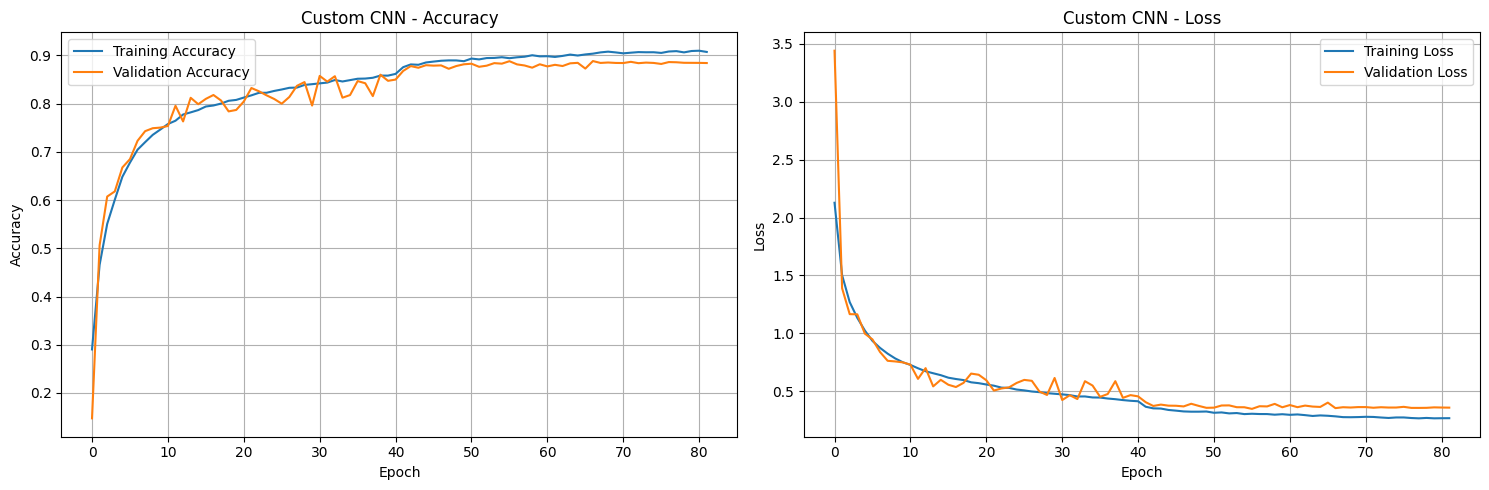

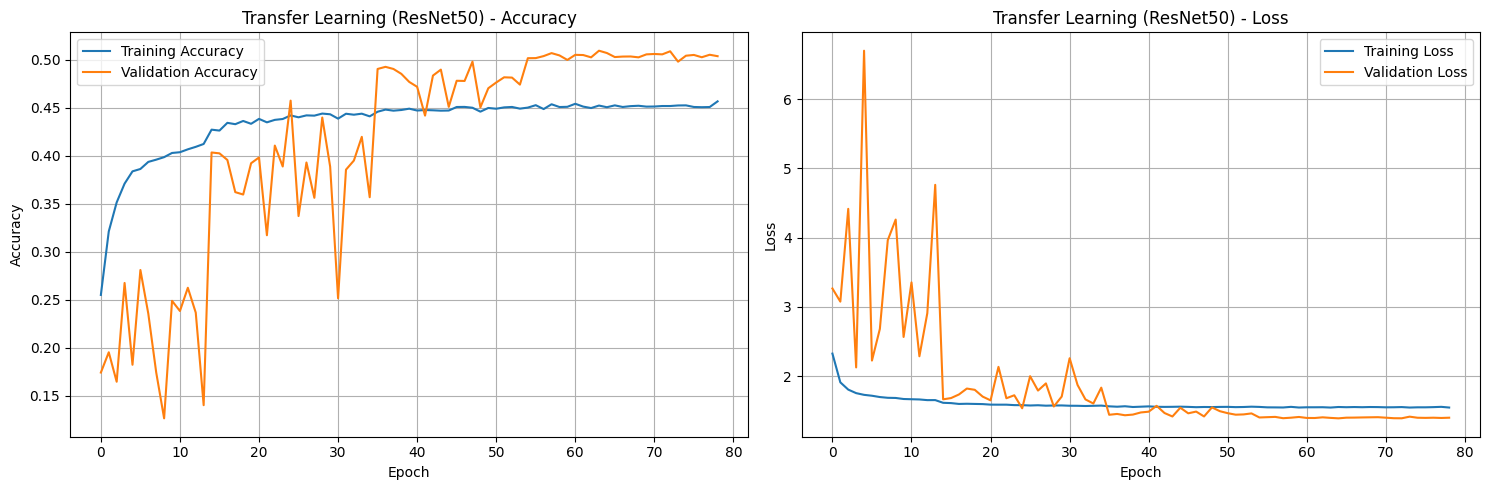

In [23]:
# Cell 13: Plot training histories
plot_training_history(history_custom, "Custom CNN")
plot_training_history(history_transfer, "Transfer Learning (ResNet50)")

In [22]:
# Cell 12: Define plot training history
def plot_training_history(history, model_name):
    """
    Plot training and validation accuracy/loss curves.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title(f'{model_name} - Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title(f'{model_name} - Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [14]:
# Cell 14: Define plot confusion matrix
def plot_confusion_matrix(cm, class_names, model_name):
    """
    Plot the confusion matrix with annotations.
    """
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

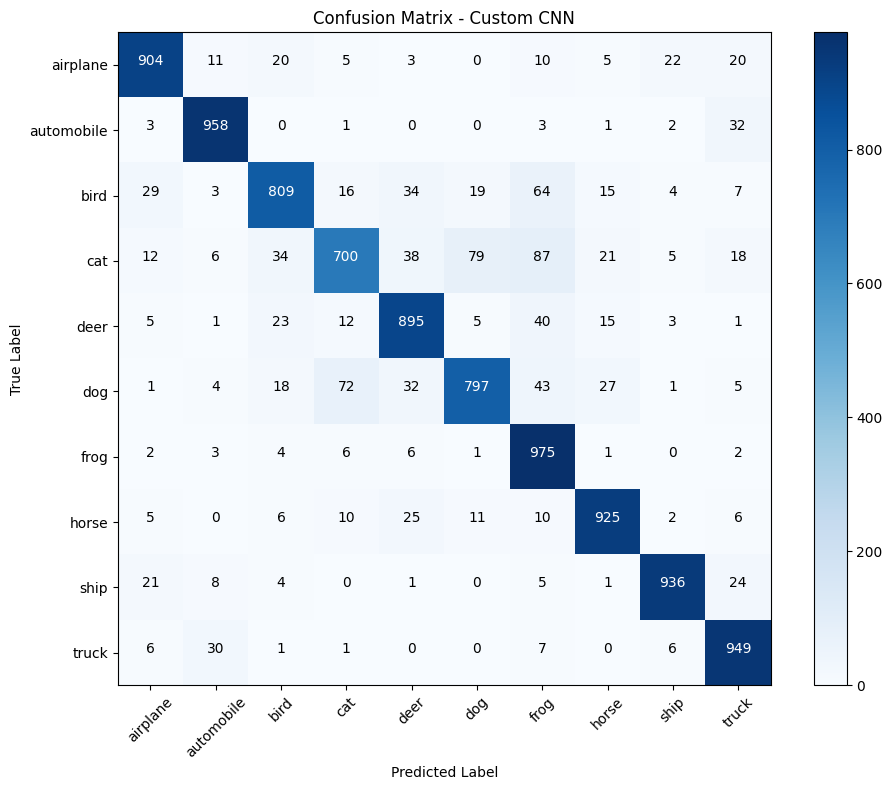

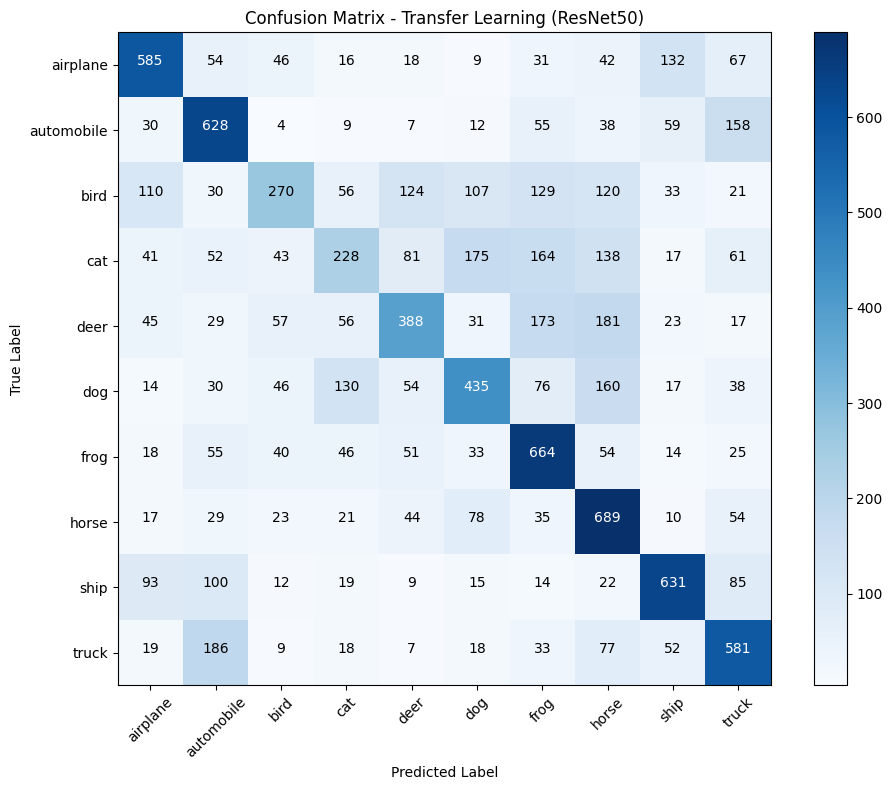

In [15]:
# Cell 15: Plot confusion matrices
plot_confusion_matrix(cm_custom, class_names, "Custom CNN")
plot_confusion_matrix(cm_transfer, class_names, "Transfer Learning (ResNet50)")

In [16]:
# Cell 16: Define hyperparameter tuning function
# Hyperparameter tuning aligns with choosing optimal settings like layers, filters, learning rate.
def hyperparameter_tuning(x_train, y_train, x_val, y_val, max_trials=5):
    """
    Perform hyperparameter tuning using Keras Tuner RandomSearch.
    """
    print("🚀 Starting Hyperparameter Tuning...")
    print(f"Max trials: {max_trials}")

    def build_model(hp):
        model = models.Sequential()

        # Tune number of convolutional layers
        for i in range(hp.Int('num_conv_layers', 2, 4)):
            model.add(layers.Conv2D(
                hp.Int(f'filters_{i}', 32, 128, step=32),
                (3, 3), activation='relu', padding='same',
                input_shape=(32, 32, 3) if i == 0 else None
            ))
            model.add(layers.BatchNormalization())
            if hp.Boolean(f'maxpool_{i}'):
                model.add(layers.MaxPooling2D((2, 2)))
            model.add(layers.Dropout(hp.Float(f'dropout_{i}', 0.1, 0.4)))

        model.add(layers.GlobalAveragePooling2D())

        # Tune dense layers
        for i in range(hp.Int('num_dense_layers', 1, 2)):
            model.add(layers.Dense(
                hp.Int(f'dense_units_{i}', 128, 512, step=128),
                activation='relu'
            ))
            model.add(layers.Dropout(hp.Float(f'dense_dropout_{i}', 0.2, 0.5)))

        model.add(layers.Dense(10, activation='softmax'))

        # Tune learning rate
        learning_rate = hp.Float('lr', 1e-4, 1e-2, sampling='log')
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        return model

    # Clear previous tuning directory
    if os.path.exists('tuning'):
        shutil.rmtree('tuning')

    tuner = kt.RandomSearch(
        build_model,
        objective='val_accuracy',
        max_trials=max_trials,
        executions_per_trial=1,
        directory='tuning',
        project_name='cifar10_cnn',
        overwrite=True
    )

    tuner.search_space_summary()

    tuner.search(
        x_train, y_train,
        epochs=20,
        validation_data=(x_val, y_val),
        batch_size=128,
        verbose=1
    )

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_model = tuner.get_best_models(num_models=1)[0]

    print("\n🏆 Best Hyperparameters:")
    print(f"Number of Conv Layers: {best_hps.get('num_conv_layers')}")
    print(f"Learning Rate: {best_hps.get('lr'):.6f}")
    for i in range(best_hps.get('num_conv_layers')):
        print(f"Conv Layer {i+1} Filters: {best_hps.get(f'filters_{i}')}")
        print(f"Conv Layer {i+1} Dropout: {best_hps.get(f'dropout_{i}'):.3f}")
    print(f"Number of Dense Layers: {best_hps.get('num_dense_layers')}")
    for i in range(best_hps.get('num_dense_layers')):
        print(f"Dense Layer {i+1} Units: {best_hps.get(f'dense_units_{i}')}")

    # Evaluate best model on validation set
    best_loss, best_accuracy = best_model.evaluate(x_val, y_val, verbose=0)
    print(f"Validation Accuracy: {best_accuracy:.4f}")
    print(f"Validation Loss: {best_loss:.4f}")

    return best_model, best_hps

In [17]:
# Cell 17: Run hyperparameter tuning (Uncomment to run; takes significant time)
best_model, best_hps = hyperparameter_tuning(x_train, y_train, x_val, y_val, max_trials=3)

Trial 3 Complete [00h 01m 24s]
val_accuracy: 0.6444000005722046

Best val_accuracy So Far: 0.7150999903678894
Total elapsed time: 00h 05m 30s


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



🏆 Best Hyperparameters:
Number of Conv Layers: 3
Learning Rate: 0.002842
Conv Layer 1 Filters: 96
Conv Layer 1 Dropout: 0.367
Conv Layer 2 Filters: 64
Conv Layer 2 Dropout: 0.256
Conv Layer 3 Filters: 32
Conv Layer 3 Dropout: 0.100
Number of Dense Layers: 1
Dense Layer 1 Units: 256
Validation Accuracy: 0.7151
Validation Loss: 0.8188


In [ ]:
# Cell 18: Define visualization functions
# Visualizations help analyze model performance, aligning with paying attention to how the system works.
def visualize_predictions(model, x_test, y_test, class_names, num_samples=15):
    """
    Visualize random sample predictions with confidence scores.
    Green for correct, red for incorrect.
    """
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    indices = np.random.choice(len(x_test), num_samples, replace=False)

    fig, axes = plt.subplots(3, 5, figsize=(15, 10))
    axes = axes.ravel()

    for i, idx in enumerate(indices):
        axes[i].imshow(x_test[idx])
        actual_label = class_names[y_true_classes[idx]]
        predicted_label = class_names[y_pred_classes[idx]]
        confidence = np.max(y_pred[idx])
        color = 'green' if y_pred_classes[idx] == y_true_classes[idx] else 'red'
        title = f"Actual: {actual_label}\nPred: {predicted_label}\nConf: {confidence:.2f}"
        axes[i].set_title(title, color=color, fontsize=10)
        axes[i].axis('off')

    plt.suptitle('Sample Predictions on CIFAR-10 Test Set\n(Green=Correct, Red=Incorrect)', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    sample_accuracy = np.sum(y_pred_classes[indices] == y_true_classes[indices]) / num_samples
    print(f"Accuracy on displayed {num_samples} samples: {sample_accuracy:.1%}")

    return indices, y_pred_classes[indices], y_true_classes[indices]

def show_confidence_analysis(model, x_test, y_test, class_names):
    """
    Visualize most confident correct and incorrect predictions.
    """
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    confidences = np.max(y_pred, axis=1)
    correct_mask = y_pred_classes == y_true_classes

    # Most confident correct
    correct_indices = np.where(correct_mask)[0]
    correct_confidences = confidences[correct_mask]
    most_confident_correct = correct_indices[np.argsort(correct_confidences)[-6:]][::-1]

    # Most confident incorrect
    incorrect_mask = ~correct_mask
    if np.any(incorrect_mask):
        incorrect_indices = np.where(incorrect_mask)[0]
        incorrect_confidences = confidences[incorrect_mask]
        most_confident_incorrect = incorrect_indices[np.argsort(incorrect_confidences)[-6:]][::-1]
    else:
        most_confident_incorrect = []

    # Plot correct
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.ravel()
    plt.suptitle('Most Confident Correct Predictions', fontsize=16, fontweight='bold')
    for i, idx in enumerate(most_confident_correct[:6]):
        axes[i].imshow(x_test[idx])
        actual = class_names[y_true_classes[idx]]
        predicted = class_names[y_pred_classes[idx]]
        conf = confidences[idx]
        axes[i].set_title(f'{actual} → {predicted}\nConf: {conf:.3f}', color='green', fontsize=10)
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

    # Plot incorrect if any
    if len(most_confident_incorrect) > 0:
        fig, axes = plt.subplots(2, 3, figsize=(12, 8))
        axes = axes.ravel()
        plt.suptitle('Most Confident Incorrect Predictions', fontsize=16, fontweight='bold')
        for i, idx in enumerate(most_confident_incorrect[:6]):
            axes[i].imshow(x_test[idx])
            actual = class_names[y_true_classes[idx]]
            predicted = class_names[y_pred_classes[idx]]
            conf = confidences[idx]
            axes[i].set_title(f'{actual} → {predicted}\nConf: {conf:.3f}', color='red', fontsize=10)
            axes[i].axis('off')
        plt.tight_layout()
        plt.show()

def detailed_prediction_analysis(model, x_test, y_test, class_names):
    """
    Perform detailed analysis including class-wise performance and confusion matrix heatmap.
    """
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    overall_accuracy = np.mean(y_pred_classes == y_true_classes)
    print(f"\n🎯 Overall Test Accuracy: {overall_accuracy:.4f}")

    print("\n📊 Class-wise Performance:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=class_names, digits=4))

    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    show_confidence_analysis(model, x_test, y_test, class_names)

    return overall_accuracy

SAMPLE PREDICTIONS VISUALIZATION - Custom CNN
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


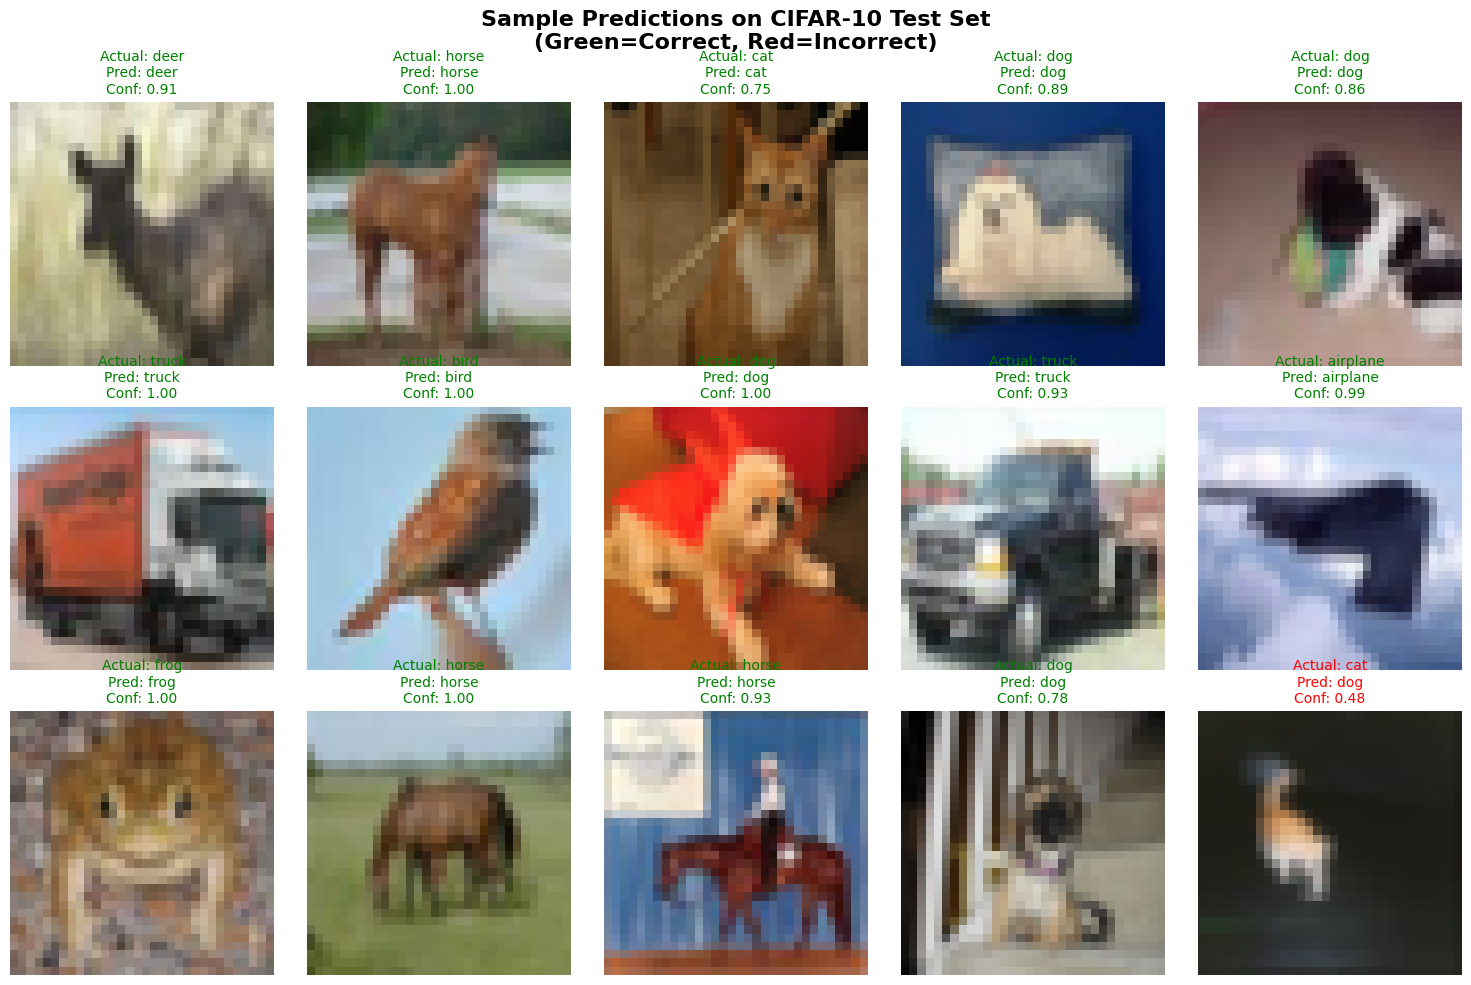

Accuracy on displayed 15 samples: 93.3%
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

🎯 Overall Test Accuracy: 0.8848

📊 Class-wise Performance:
              precision    recall  f1-score   support

    airplane     0.9150    0.9040    0.9095      1000
  automobile     0.9355    0.9580    0.9466      1000
        bird     0.8803    0.8090    0.8431      1000
         cat     0.8505    0.7000    0.7680      1000
        deer     0.8656    0.8950    0.8800      1000
         dog     0.8739    0.7970    0.8337      1000
        frog     0.7838    0.9750    0.8690      1000
       horse     0.9149    0.9250    0.9199      1000
        ship     0.9541    0.9360    0.9450      1000
       truck     0.8919    0.9490    0.9196      1000

    accuracy                         0.8848     10000
   macro avg     0.8866    0.8848    0.8834     10000
weighted avg     0.8866    0.8848    0.8834     10000



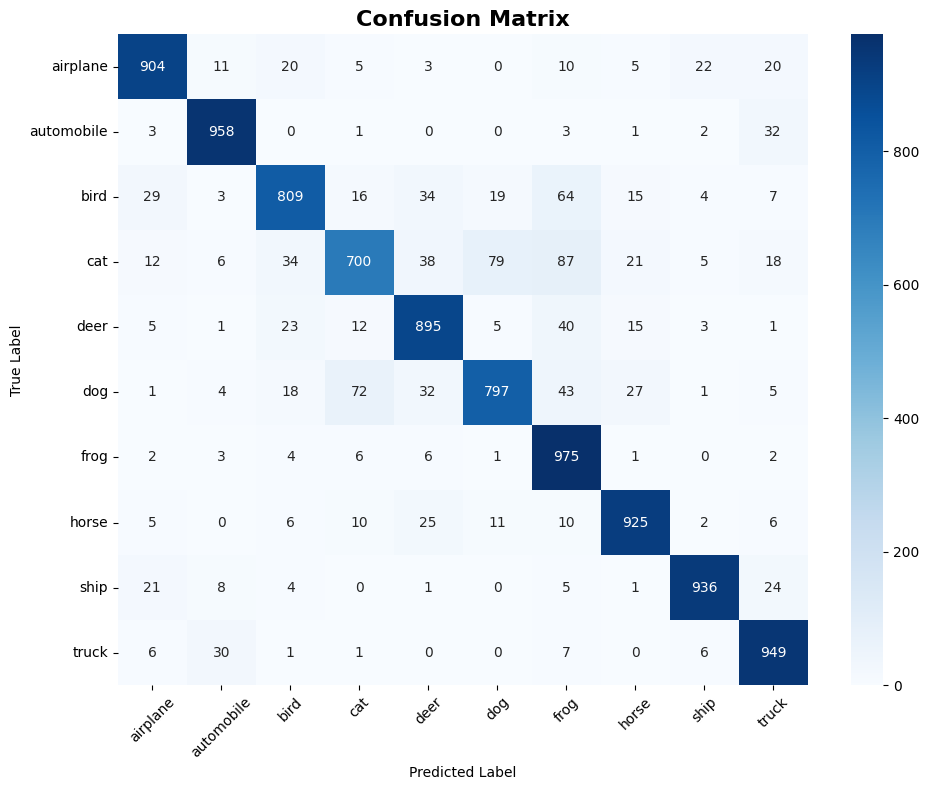

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


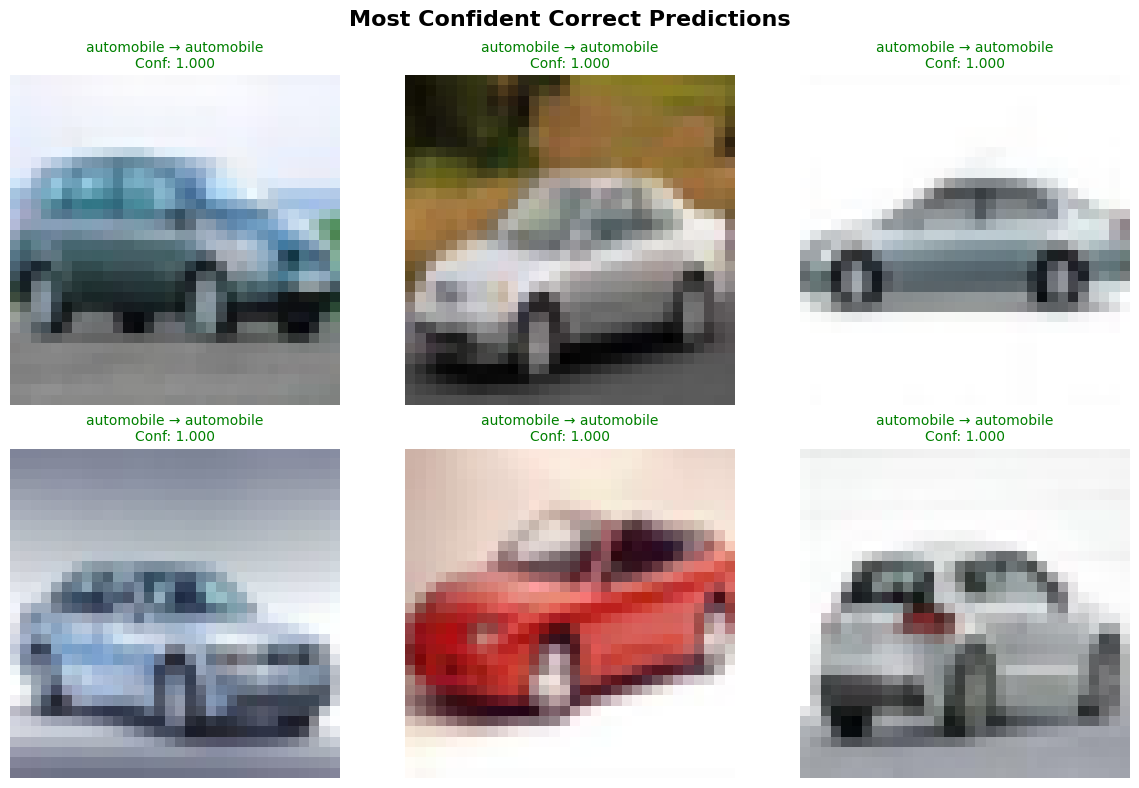

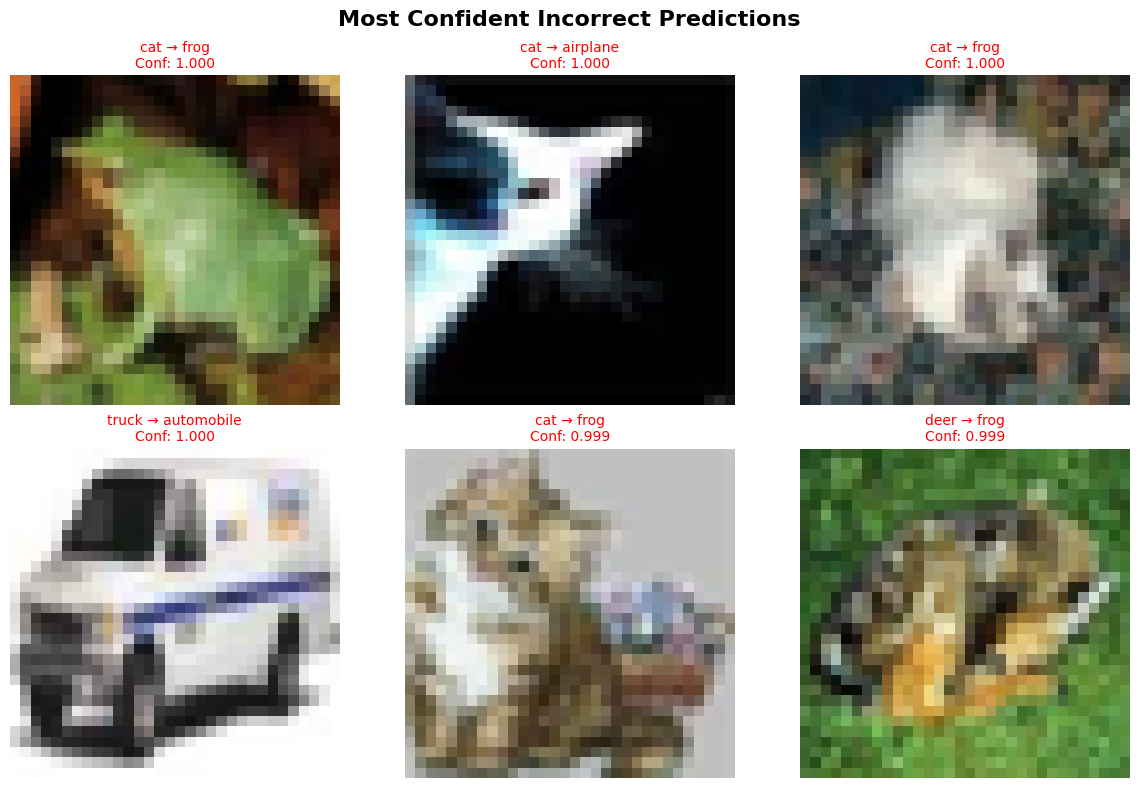

np.float64(0.8848)

In [19]:
# Cell 19: Execute visualizations for Custom CNN
# Use these to pay attention to how the model performs, as per the notes.
print("="*60)
print("SAMPLE PREDICTIONS VISUALIZATION - Custom CNN")
print("="*60)
visualize_predictions(trained_custom, x_test, y_test, class_names)
detailed_prediction_analysis(trained_custom, x_test, y_test, class_names)

# Task
Upload an image, preprocess it, and use the `trained_custom` model to predict its class. Display the image and the prediction.

## Upload image

### Subtask:
Provide code to upload an image file from the user's local machine.


**Reasoning**:
The subtask is to provide code to upload an image file from the user's local machine. This requires using the `files` module from `google.colab` and calling the `upload()` function.



In [25]:
from google.colab import files

uploaded = files.upload()

for filename in uploaded.keys():
    print(f'User uploaded file "{filename}" with length {len(uploaded[filename])} bytes')

Saving OSK.jpg to OSK.jpg
User uploaded file "OSK.jpg" with length 6045 bytes


**Reasoning**:
The previous step successfully uploaded the image file. The next step is to preprocess the uploaded image so it can be used as input for the trained model. This involves reading the image, resizing it to the expected input shape of the model (32x32), and normalizing the pixel values.



In [26]:
from PIL import Image
import io

for filename in uploaded.keys():
    img = Image.open(io.BytesIO(uploaded[filename]))
    img = img.resize((32, 32))
    img_array = np.array(img).astype('float32') / 255.0
    # The model expects a batch of images, so we add a dimension
    img_array = np.expand_dims(img_array, axis=0)

    print(f"Processed image shape: {img_array.shape}")

Processed image shape: (1, 32, 32, 3)


**Reasoning**:
The image has been uploaded and preprocessed. The next step is to use the `trained_custom` model to predict the class of the preprocessed image and display the image along with its predicted class.



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


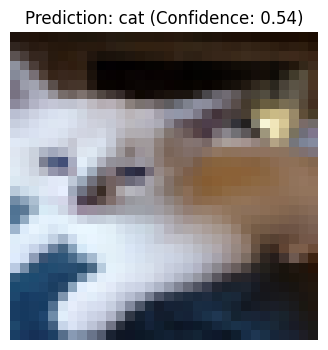

In [27]:
# Predict the class of the uploaded image
predictions = trained_custom.predict(img_array)
predicted_class_index = np.argmax(predictions, axis=1)[0]
predicted_class_name = class_names[predicted_class_index]
confidence = np.max(predictions)

# Display the image and prediction
plt.figure(figsize=(4, 4))
plt.imshow(img_array[0])
plt.title(f"Prediction: {predicted_class_name} (Confidence: {confidence:.2f})")
plt.axis('off')
plt.show()

## Summary:

### Data Analysis Key Findings

*   An image was successfully uploaded by the user.
*   The uploaded image was preprocessed by resizing it to 32x32 pixels, converting it to a normalized NumPy array, and adding a batch dimension, resulting in a shape of (1, 32, 32, 3).
*   The `trained_custom` model made a prediction on the preprocessed image, identifying the predicted class and a confidence score.
*   The uploaded image was displayed along with the model's prediction and confidence level.

### Insights or Next Steps

*   The process successfully demonstrates the pipeline for classifying a user-provided image using the trained model.
*   Consider implementing error handling for different image file types or corrupted uploads.
